## Projekt 2 - ZMUM
### Wojciech Celej

In [1]:
from tqdm import tqdm_notebook as tqdm
import warnings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.metrics import *
from sklearn.feature_selection import *
from sklearn.model_selection import *

import lightgbm as lgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

import boruta
import shap

In [3]:
X_train = pd.read_csv("artificial_train.data", sep=" ", header=None).iloc[:, 0:500].rename(str, axis="columns")
X_train.columns = ["Var{}".format(i+1) for i in range(X_train.shape[1])]
X_train_transformed = X_train.copy()
X_test_final = pd.read_csv("artificial_valid.data", sep=" ", header=None).iloc[:, 0:500].rename(str, axis="columns")
X_test_final.columns = ["Var{}".format(i+1) for i in range(X_train.shape[1])]
y_train = pd.read_csv("artificial_train.labels", header=None).iloc[:, 0].apply(lambda x: 0 if x < 0 else 1)

In [4]:
seed = 123
num_cpus = 4
nfolds = 5
test_split_ratio = 0.1

---

### Balanced accuracy

In [5]:
def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bal_accuracy = 0.5 * (tp/(tp+fp) + tn/(tn+fn))
    return bal_accuracy

def bal_ac_lgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    return "ba", balanced_accuracy(y_true, np.round(y_pred)), True

### Ważność zmiennych określona przez model

In [6]:
def model_specific_feature_importance(features, values, n_features=10):
    feature_importances = pd.DataFrame({"feature": features, "values": values})
    feature_importances = feature_importances.sort_values("values", ascending=False).head(n_features)
    sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "values", y="feature", color="#208ce4")
    plt.title("Model specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("coef")

### Metoda SHAP

In [7]:
def shap_feature_importance_tree_model(model, X_train, plot_type="bar"):
    tree_explainer = shap.TreeExplainer(model)
    shap_values = tree_explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type=plot_type)

### Graf korelacji zmiennych, funkcja zwraca kolumny do usunięcia

In [8]:
def correlated_variables(X_train, min_corr, max_corr, plot=True):
    warnings.filterwarnings('ignore')
    corr_matrix = abs(X_train.corr())
    n = corr_matrix.shape[0]
    var_list = []
    for i in range(n-1):
        for j in range(i+1, n):
            if min_corr <= corr_matrix.iloc[i, j] <= max_corr:
                var_list.append((corr_matrix.iloc[i, j], corr_matrix.index[i], corr_matrix.columns[j]))
    var_list = pd.DataFrame(var_list)
    
    if plot:
        G = nx.from_pandas_edgelist(var_list, 1, 2, create_using=nx.Graph())
        pos = nx.spring_layout(G, k=0.5)
        sns.set(rc={'figure.figsize':(10,10)})
        nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, width=6, alpha = 0.9, edge_color=var_list[0].astype(np.float), 
                edge_cmap=plt.cm.Blues, pos=pos, edge_vmin=np.max(min_corr-0.01, 0), edge_vmax=max_corr)
    
    columns_to_drop = set()
    columns_to_save = set()
    for i in range(var_list.shape[0]):
        variable_1 = var_list.iloc[i, 1]
        variable_2 = var_list.iloc[i, 2]
        if variable_1 not in columns_to_save:
            columns_to_drop.add(variable_1)
            columns_to_save.add(variable_2)
        else:
            columns_to_drop.add(variable_2)
    print(f"Columns to drop: {columns_to_drop}")
    return columns_to_drop

Columns to drop: {'Var49', 'Var154', 'Var454', 'Var106', 'Var242', 'Var434', 'Var452', 'Var443', 'Var65', 'Var29'}


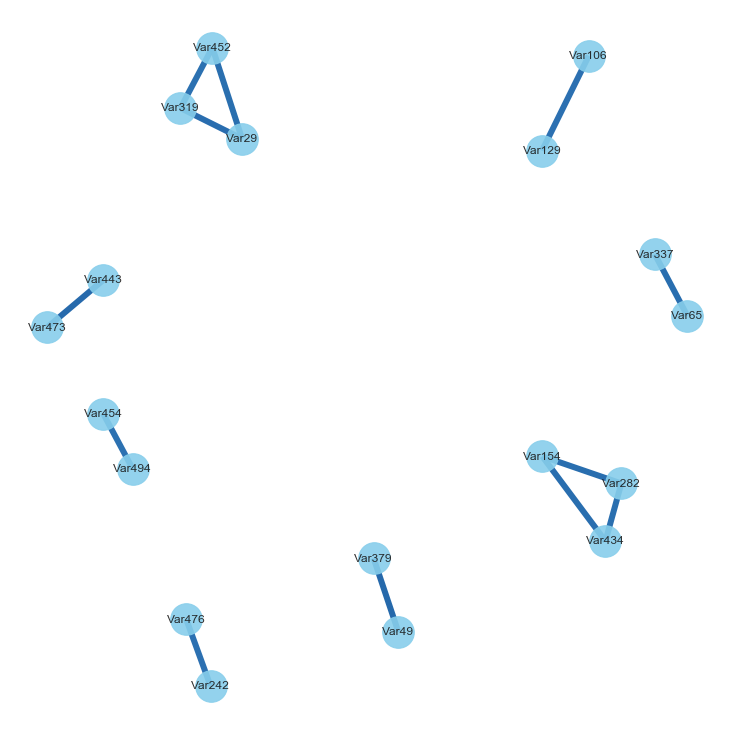

In [9]:
corr_columns_to_drop = correlated_variables(X_train, 0.95, 1)
X_train_transformed = X_train.drop(columns=corr_columns_to_drop)

### Filtrowanie 

In [10]:
def univariate_filter(X_train, y_train, n):
    selected_chi2 = SelectKBest(chi2, k=n).fit(X_train, y_train)
    selected_mut_info = SelectKBest(mutual_info_classif, k=n).fit(X_train, y_train)
    
    joined_logical_mask = np.logical_and(selected_chi2.get_support(), selected_mut_info.get_support())
    print(f"{joined_logical_mask.astype(np.int).sum()} features selected")
    return X_train.columns[joined_logical_mask]

In [11]:
filtered_columns = univariate_filter(X_train_transformed, y_train, 400)
X_train_transformed = X_train_transformed[filtered_columns]

327 features selected


### Podział zbioru na treningowy i testowy

In [12]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_transformed, y_train, test_size=test_split_ratio, random_state=seed)

### Metoda z paczki "boruta"

In [13]:
rfc = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=num_cpus)
feature_selector = boruta.BorutaPy(rfc, n_estimators="auto", verbose=2, random_state=seed)

In [14]:
feature_selector.fit(X_train_transformed.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	327
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	312
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	6
Rejected: 	312
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	6
Rejected: 	312
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	6
Rejected: 	312
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	313
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	313
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	313
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	313
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	4

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=None,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=48, n_jobs=4,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x00000294FBB54AF8>,
                                          verbose=0, warm_start=False),
         max_

In [15]:
selected_columns = X_train_cv.columns[feature_selector.support_]
selected_columns

Index(['Var129', 'Var282', 'Var319', 'Var337', 'Var339', 'Var379', 'Var456',
       'Var473', 'Var476', 'Var494'],
      dtype='object')

In [ ]:
# selected_columns = ['Var129', 'Var282', 'Var319', 'Var337', 'Var339', 'Var379', 'Var456', 'Var473', 'Var476', 'Var494']

In [16]:
X_train_lgb = X_train_cv[selected_columns]
X_test_lgb = X_test_cv[selected_columns]
X_test_final = X_test_final[selected_columns]

## LightGBM

### LGBOptimizer

In [17]:
class lgbOptimizer():
    def __init__(self, init_params, X_train, X_test, y_train, y_test, nfolds=5, niters=500, early_stopping_rounds=50):
        self.best_params = init_params
        self.best_num_iters = niters
        self.train_data = lgb.Dataset(data=X_train.values, label=y_train.values)
        self.test_data = lgb.Dataset(data=X_test.values, label=y_test.values)
        self.all_data = lgb.Dataset(data=X_train.append(X_test).values, label=y_train.append(y_test).values)
        self.nfolds = nfolds
        self.niters = niters
        self.early_stopping_rounds = early_stopping_rounds
        
        self.last_results_ = None
        self.last_best_params_ = None
        self.last_best_num_iters_ = None
    
    def set_params(self, params):
        self.best_params.update(params)
    
    def get_params(self):
        return self.best_params.copy()
    
    def evaluate_model_cv(self, eval_step=0):
        cv = lgb.cv(
            params=self.best_params,
            train_set=self.train_data,
            num_boost_round=self.niters, 
            nfold=self.nfolds,
            metrics="auc",
            stratified=True,
            shuffle=True,
            feval=bal_ac_lgb,
            early_stopping_rounds=self.early_stopping_rounds,
            verbose_eval=eval_step
        )
        cv_df = pd.DataFrame(cv)
        cv_best_result = cv_df.iloc[-1,:]
        num_iters = cv_df.shape[0]
        print(f"Best results: {cv_best_result}")
        
    def evaluate_model(self, eval_step=0):
        lgb_classifier = lgb.train(
            {**self.best_params, "num_iterations": self.best_num_iters}, 
            train_set=self.train_data, 
            feval=bal_ac_lgb, 
            valid_sets=self.test_data, 
            verbose_eval=eval_step
        )
        return lgb_classifier
        
    def get_optimal_booster(self, num_iterations=None):
        if num_iterations == None:
            num_iterations = self.best_num_iters
        lgb_classifier = lgb.train(
            {**self.best_params, "num_iterations": num_iterations}, 
            train_set=self.all_data, 
            feval=bal_ac_lgb, 
        )
        print(f"Model trained. Best params:\n{self.best_params}\nNumber of iterations: {num_iterations}")
        return lgb_classifier
    
    def optimize_model(self, params_dict):
        results = pd.DataFrame(columns=["params", "ba_mean", "ba_std", "auc_mean", "auc_std", "num_iters"])
        params_grid = list(ParameterGrid(params_dict))
        for it in tqdm(range(len(params_grid))):
            act_params = self.best_params.copy()
            params = params_grid[it]
            act_params.update(params)
            cv = lgb.cv(
                params=act_params,
                train_set=self.train_data,
                num_boost_round=self.niters, 
                nfold=self.nfolds,
                metrics="auc",
                stratified=True,
                shuffle=True,
                feval=bal_ac_lgb,
                early_stopping_rounds=self.early_stopping_rounds,
                verbose_eval=0
            )
            cv_df = pd.DataFrame(cv)
            cv_best_result = cv_df.iloc[-1,:]
            num_iters = cv_df.shape[0]
            results.loc[it] = [params, cv_best_result["ba-mean"], cv_best_result["ba-stdv"], cv_best_result["auc-mean"],
                           cv_best_result["auc-stdv"], num_iters]
        
        best = results.sort_values("ba_mean", ascending=False).iloc[0, :]
        ba_mean = best["ba_mean"]
        ba_std = best["ba_std"]
        auc_mean = best["auc_mean"]
        auc_std = best["auc_std"]
        best_iter = best["num_iters"]
        best_params = best["params"]
        print(f"Best resutlt: \nba: {ba_mean} + {ba_std}\nauc: {auc_mean} + {auc_std}")
        print(f"Best params: {best_params}\nNum of iterations: {best_iter}")
        self.last_results_ = results
        self.last_best_num_iters_ = best_iter
        self.last_best_params_ = best_params
        return best_params
              
    def update_model(self):
        self.best_params.update(self.last_best_params_)
        self.best_num_iters = self.last_best_num_iters_
        

In [18]:
init_parameters = {
    "objective": "binary",
    "n_jobs": num_cpus,
}

lgb_optimizer = lgbOptimizer(init_parameters, X_train_lgb, X_test_lgb, y_train_cv, y_test_cv, nfolds=nfolds)

### Greedy optimization

In [19]:
parameters1 = {
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
}
lgb_optimizer.optimize_model(parameters1)


Best resutlt: 
ba: 0.8758818482357213 + 0.02296680156284731
auc: 0.9362937973622871 + 0.011421886088185989
Best params: {'learning_rate': 0.04}
Num of iterations: 297


{'learning_rate': 0.04}

In [20]:
lgb_optimizer.update_model()

In [21]:
parameters2 = {
    "max_depth": [8, 10, 15, -1],
    "num_leaves": [20, 31, 40, 50, 75],
    "min_child_weight": [0.01, 0.1, 1, 5, 10, 15, 20],
    "min_child_samples": [10, 15, 20, 30]
}
lgb_optimizer.optimize_model(parameters2)


Best resutlt: 
ba: 0.881046991307656 + 0.016904603441646026
auc: 0.9359230257449648 + 0.012049784589026296
Best params: {'max_depth': -1, 'min_child_samples': 15, 'min_child_weight': 1, 'num_leaves': 50}
Num of iterations: 108


{'max_depth': -1,
 'min_child_samples': 15,
 'min_child_weight': 1,
 'num_leaves': 50}

In [22]:
lgb_optimizer.update_model()

In [23]:
parameters3 = {
    "max_bin": [100, 150, 255, 300, 350],
    "bagging_fraction": [0.75, 0.8, 0.9, 1],
    "bagging_freq": [2, 5, 10, 15, 20],
    "feature_fraction": [0.75, 0.8, 0.9, 1],
    "lambda_l2": [0.001, 0.01, 0.1, 1, 10, 100]
}
lgb_optimizer.optimize_model(parameters3)


Best resutlt: 
ba: 0.8831537952743158 + 0.015288853684962975
auc: 0.9395934564357459 + 0.014523141003426035
Best params: {'bagging_fraction': 0.75, 'bagging_freq': 5, 'feature_fraction': 0.75, 'lambda_l2': 0.1, 'max_bin': 255}
Num of iterations: 162


{'bagging_fraction': 0.75,
 'bagging_freq': 5,
 'feature_fraction': 0.75,
 'lambda_l2': 0.1,
 'max_bin': 255}

In [24]:
lgb_optimizer.update_model()

In [25]:
parameters4 = {
    "learning_rate": [0.03, 0.04, 0.05],
    "max_depth": [-1, 10, 15],
    "min_child_samples": [12, 15, 18],
    "min_child_weight": [0.8, 1, 1.2],
    "num_leaves": [45, 50, 55],
    "max_bin": [200, 220, 255]
}
lgb_optimizer.optimize_model(parameters4)


Best resutlt: 
ba: 0.8831537952743158 + 0.015288853684962975
auc: 0.9395934564357459 + 0.014523141003426035
Best params: {'learning_rate': 0.04, 'max_bin': 200, 'max_depth': -1, 'min_child_samples': 15, 'min_child_weight': 1, 'num_leaves': 50}
Num of iterations: 162


{'learning_rate': 0.04,
 'max_bin': 200,
 'max_depth': -1,
 'min_child_samples': 15,
 'min_child_weight': 1,
 'num_leaves': 50}

In [26]:
lgb_optimizer.update_model()

In [27]:
parameters5 = {
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "bagging_fraction": [0.6, 0.7, 0.75, 0.8],
    "feature_fraction": [0.6, 0.7, 0.75, 0.8],
    "lambda_l2": [0.05, 0.1, 0.2, 0.5]
}
lgb_optimizer.optimize_model(parameters5)


Best resutlt: 
ba: 0.8831537952743158 + 0.015288853684962975
auc: 0.9395934564357459 + 0.014523141003426035
Best params: {'bagging_fraction': 0.75, 'feature_fraction': 0.75, 'lambda_l2': 0.1, 'learning_rate': 0.04}
Num of iterations: 162


{'bagging_fraction': 0.75,
 'feature_fraction': 0.75,
 'lambda_l2': 0.1,
 'learning_rate': 0.04}

In [28]:
lgb_optimizer.update_model()

In [33]:
lgb_optimizer.get_params()

{'objective': 'binary',
 'n_jobs': 4,
 'learning_rate': 0.04,
 'max_depth': -1,
 'min_child_samples': 15,
 'min_child_weight': 1,
 'num_leaves': 50,
 'bagging_fraction': 0.75,
 'bagging_freq': 5,
 'feature_fraction': 0.75,
 'lambda_l2': 0.1,
 'max_bin': 200}

### Wybrane parametry

In [18]:
# choosen_params = {
#     'objective': 'binary',
#     'n_jobs': 4,
#     'learning_rate': 0.04,
#     'max_depth': -1,
#     'min_child_samples': 15,
#     'min_child_weight': 1,
#     'num_leaves': 50,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 5,
#     'feature_fraction': 0.75,
#     'lambda_l2': 0.1,
#     'max_bin': 200
# }

# lgb_optimizer.set_params(choosen_params)
# lgb_optimizer.best_num_iters = 162

In [34]:
lgb_optimizer.evaluate_model_cv()

Best results: auc-mean    0.939593
auc-stdv    0.014523
ba-mean     0.883154
ba-stdv     0.015289
Name: 161, dtype: float64


In [37]:
lgb_classifier = lgb_optimizer.evaluate_model(10)
y_pred_lgb = lgb_classifier.predict(X_test_lgb)
balanced_accuracy(y_test_cv, np.round(y_pred_lgb))

[10]	valid_0's binary_logloss: 0.572447	valid_0's ba: 0.824242
[20]	valid_0's binary_logloss: 0.480188	valid_0's ba: 0.850962
[30]	valid_0's binary_logloss: 0.427055	valid_0's ba: 0.85
[40]	valid_0's binary_logloss: 0.389087	valid_0's ba: 0.865137
[50]	valid_0's binary_logloss: 0.361903	valid_0's ba: 0.870348
[60]	valid_0's binary_logloss: 0.340403	valid_0's ba: 0.870348
[70]	valid_0's binary_logloss: 0.326537	valid_0's ba: 0.875638
[80]	valid_0's binary_logloss: 0.310543	valid_0's ba: 0.875638
[90]	valid_0's binary_logloss: 0.304695	valid_0's ba: 0.876441
[100]	valid_0's binary_logloss: 0.299554	valid_0's ba: 0.881975
[110]	valid_0's binary_logloss: 0.291064	valid_0's ba: 0.881975
[120]	valid_0's binary_logloss: 0.28695	valid_0's ba: 0.886466
[130]	valid_0's binary_logloss: 0.28102	valid_0's ba: 0.886466
[140]	valid_0's binary_logloss: 0.280507	valid_0's ba: 0.881975
[150]	valid_0's binary_logloss: 0.276785	valid_0's ba: 0.881975
[160]	valid_0's binary_logloss: 0.274989	valid_0's ba: 

0.8819751103974307

## LogisticRegression - Lasso L1 reg

In [38]:
lasso_model = LogisticRegressionCV(Cs=20, cv=nfolds, penalty="l1", scoring="balanced_accuracy", solver="liblinear", n_jobs=num_cpus)

In [39]:
lasso_model.fit(X_train_cv, y_train_cv)

LogisticRegressionCV(Cs=20, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring='balanced_accuracy',
                     solver='liblinear', tol=0.0001, verbose=0)

In [40]:
y_pred_lasso = lasso_model.predict_proba(X_test_cv)[:,1]
balanced_accuracy(y_test_cv, np.round(y_pred_lasso))

0.6269281177538059

In [41]:
coefs = lasso_model.coef_.ravel()
features_mask = [True if i!=0 else False for i in coefs]
X_train_cv.columns[features_mask]

Index(['Var337', 'Var339', 'Var379', 'Var476', 'Var494'], dtype='object')

In [42]:
best_c = lasso_model.C_
print(best_c)
itemindex = np.where(lasso_model.Cs_==best_c)[0].item()
ba_results = lasso_model.scores_[1][:, itemindex]
print(f"ba: {ba_results.mean()} + {ba_results.std()}")

[0.00026367]
ba: 0.6061028975517078 + 0.027893229338069668


## Finalna predykcja

In [54]:
optimal_booster = lgb_optimizer.get_optimal_booster(num_iterations=150)
y_pred_final = optimal_booster.predict(X_test_final)

Model trained. Best params:
{'objective': 'binary', 'n_jobs': 4, 'learning_rate': 0.04, 'max_depth': -1, 'min_child_samples': 15, 'min_child_weight': 1, 'num_leaves': 50, 'bagging_fraction': 0.75, 'bagging_freq': 5, 'feature_fraction': 0.75, 'lambda_l2': 0.1, 'max_bin': 200}
Number of iterations: 150


#### Zapis wyniku

In [55]:
np.savetxt("WOJCEL_artificial_prediction.txt", y_pred_final, fmt='%.18f',)

## Krzywe ROC

In [45]:
fpr1, tpr1, thresholds = roc_curve(y_test_cv, y_pred_lgb)
fpr2, tpr2, thresholds = roc_curve(y_test_cv, y_pred_lasso)
x = np.linspace(0, 1, 100)

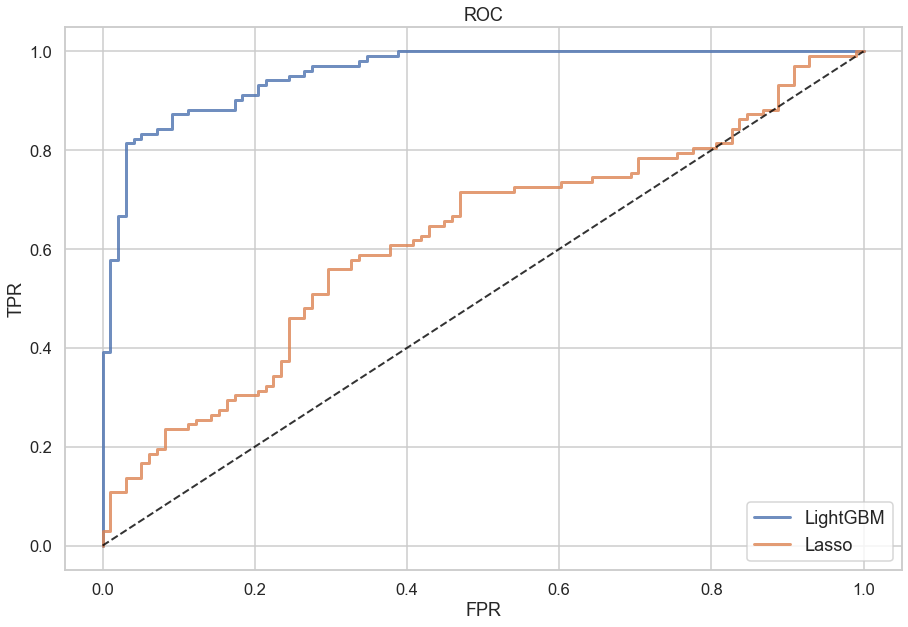

In [46]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1, linewidth = 3, alpha = 0.8)
plt.plot(fpr2, tpr2, linewidth = 3, alpha = 0.8)
plt.plot(x, x, linewidth=2, alpha=0.8, linestyle="--", color="black")
plt.legend(['LightGBM', 'Lasso'], loc='lower right', prop={'size': 18})
plt.title("ROC", size = 18)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [47]:
roc_auc_score(y_test_cv, y_pred_lgb)

0.9568827531012405

In [48]:
roc_auc_score(y_test_cv, y_pred_lasso)

0.6187474989995998

## Wyjaśnienie zmiennych

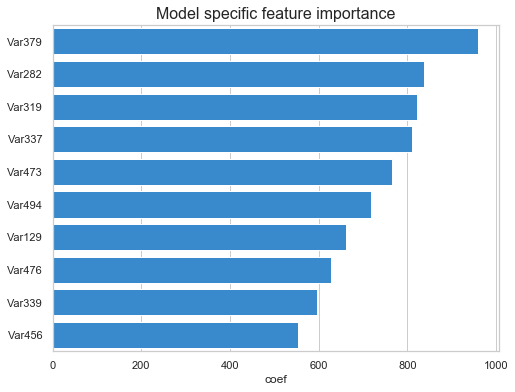

In [49]:
model_specific_feature_importance(X_train_lgb.columns, optimal_booster.feature_importance())

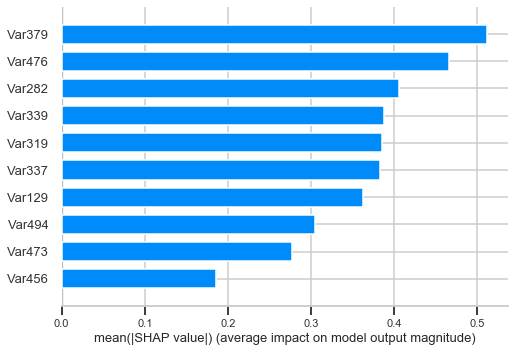

In [50]:
shap_feature_importance_tree_model(optimal_booster, X_train_lgb)

In [51]:
new_model = lgb.LGBMClassifier()
new_model.fit(X_train_cv, y_train_cv)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

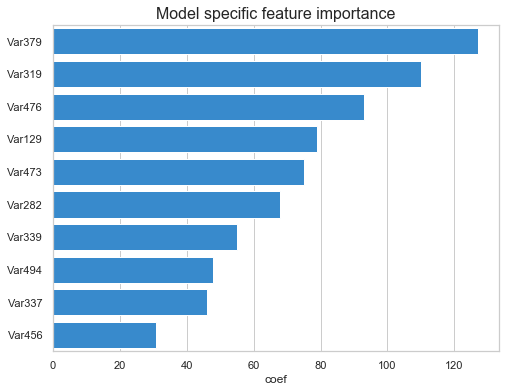

In [52]:
model_specific_feature_importance(X_train_cv.columns, new_model.feature_importances_)

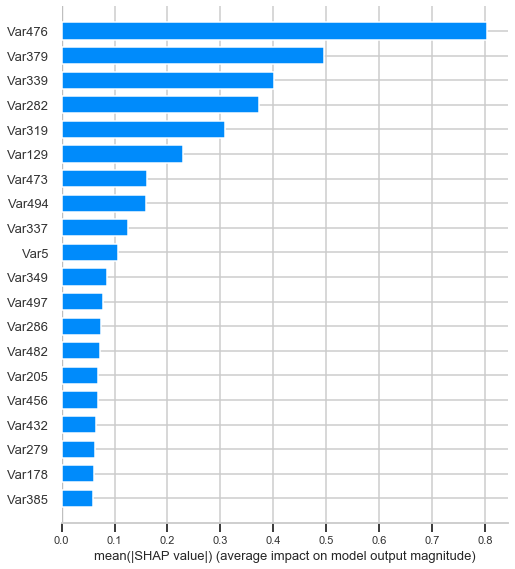

In [53]:
shap_feature_importance_tree_model(new_model, X_train_cv)